<a href="https://colab.research.google.com/github/SaraFattouh/Keypoint-Detection/blob/main/Keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### Description
In this project we will build and train a cat eyes and nose keypoint detector model using tf.keras. We will use an autoencoder like architecture, which first encodes the data, then decodes it to its original size. To implement such kind of models, you should take a look at the following classes and methods: `Funcitonal API, MaxPooling2D, Conv2DTranspose`.


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4889041280524337658
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16961047956765411111
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3580020605047321379
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695549568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5290329512347422180
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


## Prepare dataset

* Download the Cats dataset. We will only use a subset of the original dataset, the CAT_00 folder. Here you can find more information about the dataset: https://www.kaggle.com/crawford/cat-dataset
* Preprocess the data. You can find some help here: https://github.com/kairess/cat_hipsterizer/blob/master/preprocess.py
  * Following the steps in the link above, read and resize the images to be 128x128.
  * Keep only the left eye, right eye and nose coordinates.
  * Create a keypoint heatmap from the keypoints. A 128x128x3 channel image, where the first channel corresponds to left eye heatmap, the sencond channel corresponds to the right eye heatmap and the third channel corresponds to the nose heatmap. To do this:
    1. At each keypoint, draw a circle with its corresponding color. For this, use the following method: `cv2.circle(<heatmap>, center=<keypoint_coord>, radius=2, color=<keypoint_color>, thickness=2)`
    2. Then smooth the heatmap with a 5x5 Gauss filter: `<heatmap> = cv2.GaussianBlur(<heatmap>, (5,5), 0)` 
  * Then crop each image and heatmap:
    1. Define the bounding box, select the min and max keypoint coordinates: `x1, y1, x2, y2`.
    2. Add a 20x20 border around it: `x1, y1, x2, y2 = x1-20, y1-20, x2+20, y2+20`.
    3. Then crop the image and the heatmap using the extended bounding box.  
  * Finally, resize the images and the heatmaps to be 64x64.
* Split the datasets into train-val-test sets (ratio: 60-20-20), without shuffling.
* Print the size of each set and plot 5 training images and their corresponding masks.
* Normalize the datasets. All value should be between 0.0 and 1.0. *Note: you don't have to use standardization, you can just divide them by 255.*

In [ ]:
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1wGwNi8t-UKAKs-LQL3dG-D8dzGVPHv2w" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1wGwNi8t-UKAKs-LQL3dG-D8dzGVPHv2w" -o CAT_00.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1539      0 --:--:-- --:--:-- --:--:--  1539
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  402M    0  402M    0     0  40.4M      0 --:--:--  0:00:09 --:--:-- 50.2M


In [ ]:
!unzip CAT_00.zip

Archive:  CAT_00.zip
   creating: CAT_00/
 extracting: CAT_00/00000001_000.jpg  
  inflating: CAT_00/00000001_000.jpg.cat  
 extracting: CAT_00/00000001_005.jpg  
  inflating: CAT_00/00000001_005.jpg.cat  
 extracting: CAT_00/00000001_008.jpg  
  inflating: CAT_00/00000001_008.jpg.cat  
 extracting: CAT_00/00000001_011.jpg  
  inflating: CAT_00/00000001_011.jpg.cat  
 extracting: CAT_00/00000001_012.jpg  
  inflating: CAT_00/00000001_012.jpg.cat  
 extracting: CAT_00/00000001_016.jpg  
  inflating: CAT_00/00000001_016.jpg.cat  
 extracting: CAT_00/00000001_017.jpg  
  inflating: CAT_00/00000001_017.jpg.cat  
 extracting: CAT_00/00000001_020.jpg  
  inflating: CAT_00/00000001_020.jpg.cat  
  inflating: CAT_00/00000001_024.jpg  
  inflating: CAT_00/00000001_024.jpg.cat  
  inflating: CAT_00/00000001_027.jpg  
  inflating: CAT_00/00000001_027.jpg.cat  
 extracting: CAT_00/00000001_029.jpg  
  inflating: CAT_00/00000001_029.jpg.cat  
 extracting: CAT_00/00000002_001.jpg  
  inflating: CAT_

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas
import skimage
import sklearn
import tensorflow as tf

In [ ]:
import random
import dlib, cv2, os
import pandas as pd
import numpy as np

img_size = 128
dirname = 'CAT_00'
base_path = '/content/CAT_00'
file_list = sorted(os.listdir(base_path))

#random.shuffle(file_list)

dataset = {
  'imgs': [],
  'lmks': [],
  'bbs': [],
  'heatmaps':[],
  'cropped_imgs':[],
  'cropped_heatmaps':[]
  
}

def resize_img(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size) / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=[0, 0, 0])
    return new_im , ratio, top, left

for f in file_list:
    if not '.cat' in f:
      continue

  # read landmarks
    landmarks = np.genfromtxt(os.path.join(base_path, f),
                              delimiter=' ',
                              dtype=np.int32,
                             )[1:7].reshape((-1, 2))
    #print(f'landmarks before {landmarks}')

  # load image
    img_filename, ext = os.path.splitext(f)
    img = cv2.imread(os.path.join(base_path, img_filename))
    #print(f'image before {img.shape}')

  # resize image and relocate landmarks
    img, ratio, top, left = resize_img(img)
    landmarks = ((landmarks * ratio) + np.array([left, top])).astype(np.int32)
    bb = np.array([np.min(landmarks, axis=0), np.max(landmarks, axis=0)])
    # print(f'landmarks after {landmarks}')
    # print(f'image after {img.shape}')

    dataset['imgs'].append(img)
    dataset['lmks'].append(landmarks.flatten())
    dataset['bbs'].append(bb.flatten())
    # print(f'bb {bb}')
if not os.path.exists('dataset'):
  os.mkdir('dataset')
np.save('dataset/%s.npy' % dirname, np.array(dataset))

print(len(dataset['imgs']))

1706


## **Heatmaps** **Creation** 

In [ ]:
def gaussian(xL, yL, H, W, sigma=5):

    channel = [np.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2))
     for r in range(H) for c in range(W)]
    channel = np.array(channel, dtype=np.float32)

    #print( np.sum(channel.astype(np.int32)) )

    channel = np.reshape(channel, newshape=(H, W))

    return channel

In [ ]:
#Generate heatmaps for one sample image

def create_single_Heatmap(lmk):

  heatmaps = []

  for i in range(0, 6, 2):
      x = int(lmk[i])
      y = int(lmk[i + 1])
      heatmap = gaussian(x, y, 128, 128)
      heatmaps.append(heatmap)
      
  heatmaps = np.array(heatmaps)
  
  return heatmaps
  


In [ ]:
def generate_heatmaps():

 dataset['heatmaps'] = []

 for lmk in dataset['lmks']:
    heatmap = create_single_Heatmap(lmk)
    dataset['heatmaps'].append(heatmap)


In [ ]:
generate_heatmaps()

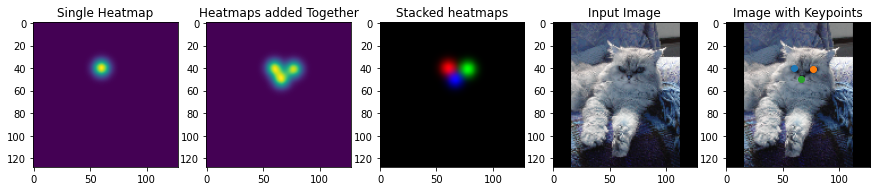

(128, 128, 3)


In [ ]:
#Generate heatmaps for one sample image

lmk = dataset['lmks'][0]
heatmaps = []

for i in range(0, 6, 2):
    x = int(lmk[i])
    y = int(lmk[i + 1])
    heatmap = gaussian(x, y, 128, 128)
    heatmaps.append(heatmap)
    
heatmaps = np.array(heatmaps)

plt.figure(figsize=(15,15))

plt.subplot(1,5,1)
plt.imshow(heatmaps[0])
plt.title("Single Heatmap")

plt.subplot(1,5,2)
plt.imshow(heatmaps.sum(axis=0))
plt.title("Heatmaps added Together")


no_img = 3
img = heatmaps[0]/no_img + heatmaps[1]/no_img + heatmaps[2]/no_img 
helloImage = cv2.merge ( (heatmaps[0], heatmaps[1],heatmaps[2]) )
stack_img =  np.dstack((heatmaps[0], heatmaps[1],heatmaps[2]))

plt.subplot(1,5,3)
plt.imshow(stack_img, cmap='gray')
plt.title("Stacked heatmaps")


plt.subplot(1,5,4)
plt.imshow(dataset['imgs'][0], cmap='gray')
plt.title("Input Image")

plt.subplot(1,5,5)
for i in range(0, len(dataset['lmks'][0])-1, 2):
  x = int(dataset['lmks'][0][i])
  y = int(dataset['lmks'][0][i+1])
  plt.scatter(x,y)
plt.imshow(dataset['imgs'][00].reshape(128,128,3), cmap='gray')
plt.title("Image with Keypoints")

plt.show()
print(stack_img.shape)




# **Images and Heatmaps Cropping**

In [ ]:
def crop_images():

  dataset['cropped_imgs'] = []

  for i in range(len(dataset['imgs'])):
    img = dataset['imgs'][i]
    bb = dataset['bbs'][i]

    if img is None or img.size == 0:
      print("image is empty")
      break

    x1 = max(bb[0] - 20, 0) #avoid negative extended bounding box
    y1 = max(bb[1] - 20, 0)
    x2 = bb[2] + 20
    y2 = bb[3] + 20

    #img = cv2.rectangle(img,(x1, y1),(x2,y2),(255,0,111),2)
    cropped_img = img[y1:y2, x1:x2]
    resized_img = cv2.resize(cropped_img, (64,64))
    dataset['cropped_imgs'].append(resized_img)
    

In [ ]:
crop_images()

In [ ]:
def crop_heatmaps():

   dataset['cropped_heatmaps'] = []
   
   for i in range(len(dataset['heatmaps'])):

        cropped_heats = []
        heatmaps = dataset['heatmaps'][i]
        bb = dataset['bbs'][i]
        

        x1 = max(bb[0] - 20, 0) #avoid negative coordinates of the extended bounding box
        y1 = max(bb[1] - 20, 0)
        x2 = bb[2] + 20
        y2 = bb[3] + 20

        for heat in heatmaps:

            cropped_heat = heat[y1:y2, x1:x2]
            resized_heat = cv2.resize(cropped_heat, (64, 64))
            #plt.imshow(resized_heat)
          
            cropped_heats.append(resized_heat)

            np.array(cropped_heats)

        stack_img =  np.dstack((cropped_heats[0], cropped_heats[1],cropped_heats[2]))  
        dataset['cropped_heatmaps'].append(stack_img)
      

      

In [ ]:
crop_heatmaps()



In [ ]:
print(dataset['cropped_heatmaps'][0].shape)

(64, 64, 3)


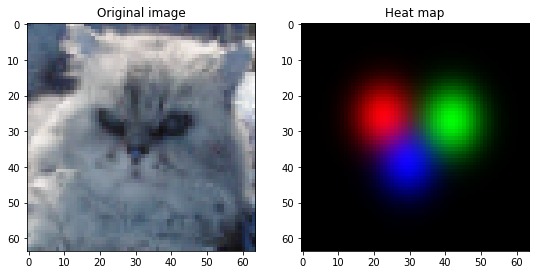

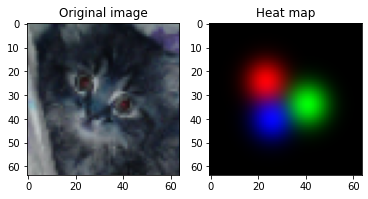

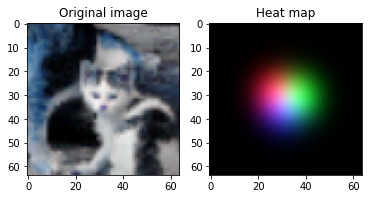

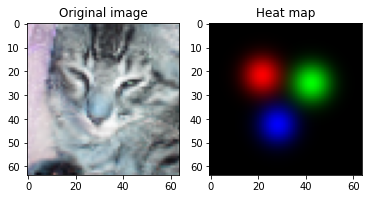

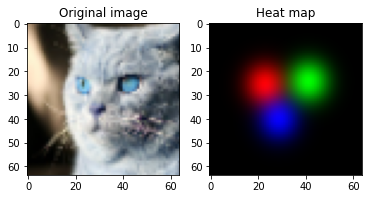

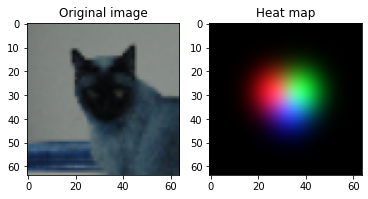

In [ ]:
plt.figure(figsize=(9,9))

for i in range(6):

  plt.subplot(1,2,1)
  plt.imshow(dataset['cropped_imgs'][i])
  plt.title("Original image")

  plt.subplot(1,2,2)
  plt.imshow(dataset['cropped_heatmaps'][i])
  plt.title("Heat map")


  plt.show()

In [ ]:
res = crop_heatmaps()


In [ ]:
print(dataset['cropped_heatmaps'][0].shape)

(64, 64, 3)


## Data augmentation
  * Augment the training set using `ImageDataGenerator`. The parameters should be the following: `featurewise_center=False, featurewise_std_normalization=False, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2`.
  * When creating the generator(s), use shuffling with a seed value of 1 and batch size of 32.
  * To validate that the augmentation is working, plot 5 original images with their corresponding transformed (augmented) images and masks.

**Keep in mind:** To augment the inputs and targets the same way, you should create 2 separate generator, then you can zip them together. 


# **Generators Creation**

## Training and evaluation 
  * Train the model for 30 epochs without early stopping.
  * Plot the training curve (train/validation loss).
  * Evaluate the trained model on the test set.
  * Plot some (5) predictions with their corresponding GT heatmap and input. You should mark the location of each keypoint on the image. *Note: it might be worth to take a look at this answer: https://stackoverflow.com/a/17386204*

## Define the model
Define the following architecture in tf.keras:
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
bottleneck_1 (Conv2D)        (None, 32, 32, 160)       5243040   
_________________________________________________________________
bottleneck_2 (Conv2D)        (None, 32, 32, 160)       25760     
_________________________________________________________________
upsample_1 (Conv2DTranspose) (None, 64, 64, 3)         1920      
=================================================================
Total params: 5,530,880
Trainable params: 5,530,880
Non-trainable params: 0
_________________________________________________________________
```
* Use relu and `padding='same'` for each layer.
* Use a 2x2 `Conv2DTranspose` layer without bias to upsample the result. 
* `block1_conv1`, `block1_conv2`, `block2_conv1` and `block2_conv2` are 3x3 convolutions.
* `bottleneck_1` is a 16x16 and `bottleneck_2` is a 1x1 convolution.
* For optimizer use RMSProp, and MSE as loss function.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [ ]:
def fcnet(input_size=(64, 64, 3)):

  #Model Building and Compiling

  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(64, 64, 3), padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))


  model.add(Conv2D(160, (16, 16), activation='relu', padding='same'))
  model.add(Conv2D(160, (1, 1), activation='relu', padding='same'))


  model.add(Conv2DTranspose(filters = 3, 
                            kernel_size =(2,2),
                            strides=(2, 2),
                            activation='relu',
                            padding='same',
                            use_bias=False
                          ))
  return model
model = fcnet(input_size=(64, 64, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 160)       5243040   
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 160)      

In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(loss='mse', optimizer = opt,
              metrics=['mean_squared_error'])

In [ ]:
# working solution
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split ( dataset['cropped_imgs'],
                                                      dataset['cropped_heatmaps'],
                                                      test_size=0.20, 
                                                      random_state=101)

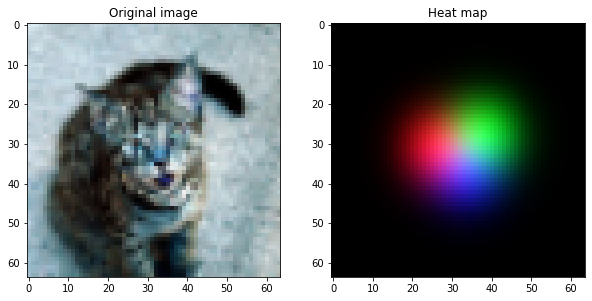

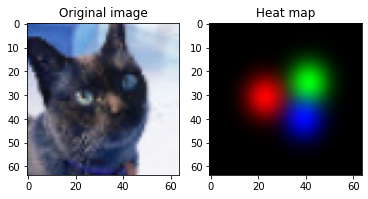

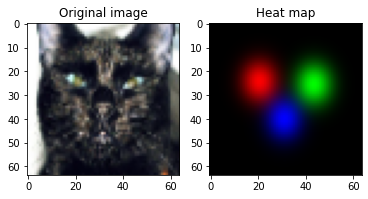

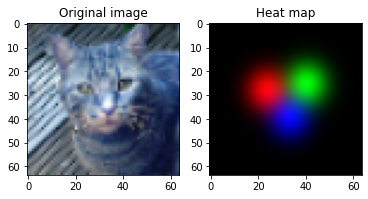

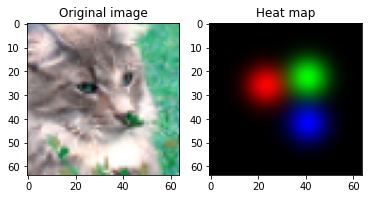

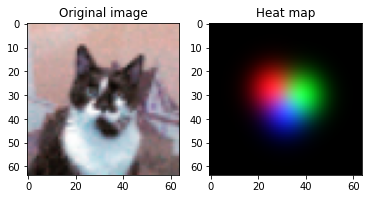

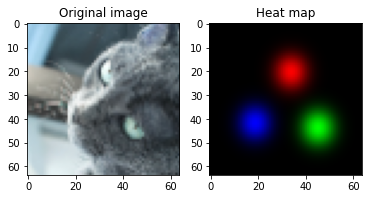

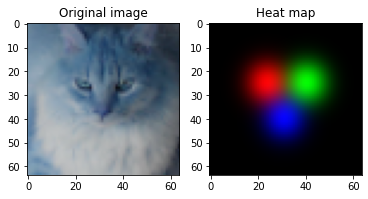

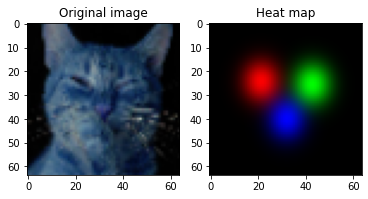

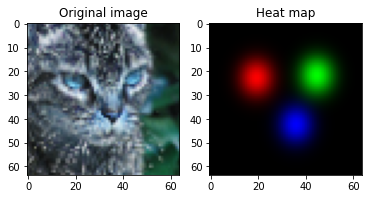

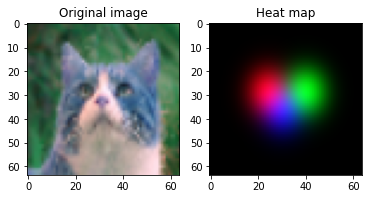

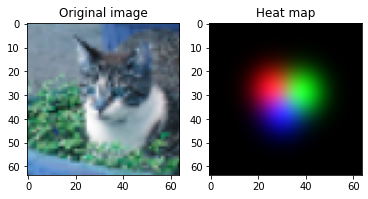

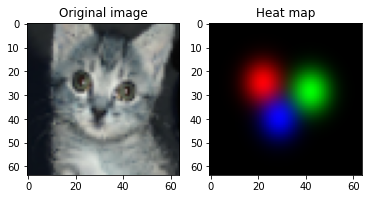

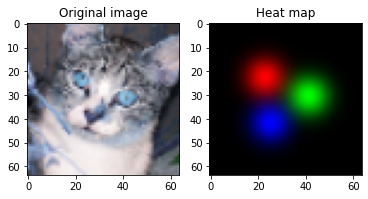

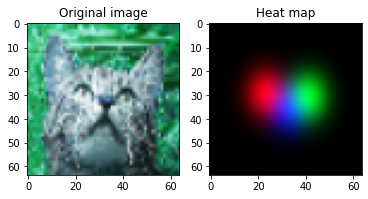

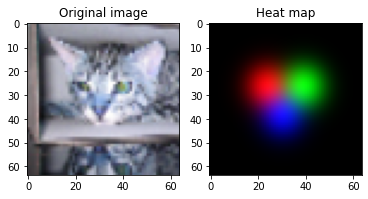

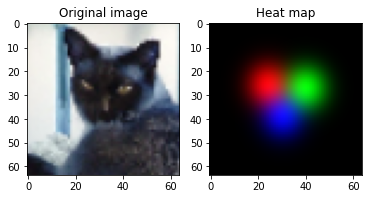

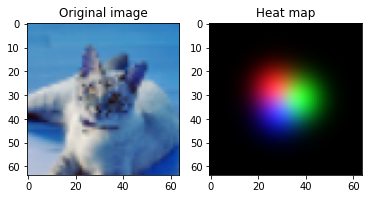

In [ ]:
#plot some train pairs samples

plt.figure(figsize=(10,10))

for i in range(18):
    plt.subplot(1,2,1)
    plt.imshow(x_train[i])
    plt.title("Original image")

    plt.subplot(1,2,2)
    plt.imshow(y_train[i])
    plt.title("Heat map")

    plt.show()

(32, 64, 64, 3)
(64, 64, 3)


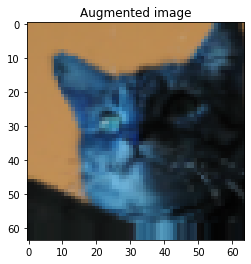

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

save_path = "/content/Aug_images"
if not os.path.exists('Aug_images'):
  os.mkdir('Aug_images')

datagen = ImageDataGenerator(featurewise_center=False,
                            featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale=1.0/255.0, #Normalization
                             zoom_range=0.2,
                             validation_split=0.2)
	# prepare iterators
train_it = datagen.flow(np.array(x_train),
                        np.array(y_train),
                        batch_size=32,
                        save_to_dir=save_path, 
                        save_prefix='aug',
                        save_format='png')

test_it = datagen.flow(np.array(x_test),
                       np.array(y_test), batch_size=32,
                       save_to_dir=save_path, 
                        save_prefix='aug',
                        save_format='png')


#plotsample of the augmented input images

batch=next(train_it)  # returns the next batch of images and labels 
print(batch[0].shape) # batch[0] is the images, batch[1] are the labels
img=batch[0][5]   # this is the first image  batch[0][1] would be the next image
print (img.shape)
plt.title("Augmented image")
plt.imshow(img)   

In [ ]:
if not os.path.exists('Aug_images'):
  os.mkdir('Aug_images')

history = model.fit(train_it, 
                    steps_per_epoch=len(train_it),
                    validation_data = train_it,
                    validation_steps=len(train_it),
                    epochs=30, 
                    verbose=1
                    )



Epoch 1/30
43/43 [==============================] - 6s 141ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 2/30
43/43 [==============================] - 6s 139ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 3/30
43/43 [==============================] - 6s 137ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0165 - val_mean_squared_error: 0.0165
Epoch 4/30
43/43 [==============================] - 6s 136ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 5/30
43/43 [==============================] - 6s 137ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0151 - val_mean_squared_error: 0.0151
Epoch 6/30
43/43 [==============================] - 6s 138ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 7/30
43/43 [==========

In [ ]:
history.history

{'loss': [0.022113624960184097,
  0.019103070721030235,
  0.017473869025707245,
  0.016384150832891464,
  0.0157952718436718,
  0.015266923233866692,
  0.01492366660386324,
  0.014544378034770489,
  0.014464245177805424,
  0.014140232466161251,
  0.014021097682416439,
  0.01387473102658987,
  0.013641329482197762,
  0.013530259020626545,
  0.013376585207879543,
  0.013252438977360725,
  0.013256990350782871,
  0.013043447397649288,
  0.012908777222037315,
  0.012758065015077591,
  0.012736821547150612,
  0.012703276239335537,
  0.012554585002362728,
  0.0114060053601861,
  0.011137140914797783,
  0.010982010513544083,
  0.010836297646164894,
  0.0106269009411335,
  0.010623348876833916,
  0.010556934401392937],
 'mean_squared_error': [0.022113624960184097,
  0.019103070721030235,
  0.017473869025707245,
  0.016384150832891464,
  0.0157952718436718,
  0.015266923233866692,
  0.01492366660386324,
  0.014544378034770489,
  0.014464245177805424,
  0.014140232466161251,
  0.0140210976824164

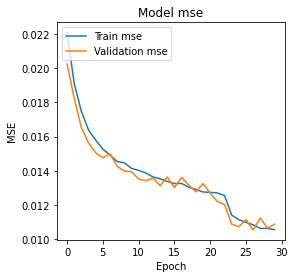

In [ ]:
# Plot training & validation mse values
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model mse')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train mse', 'Validation mse'], loc='upper left')



In [ ]:
loss, accuracy = model.evaluate(test_it, steps=len(test_it), verbose=0)
print(' loss=%.3f' % (loss))

 loss=0.011


batch shape  (32, 64, 64, 3)
predicted value shape  (64, 64, 3)
(64, 64)


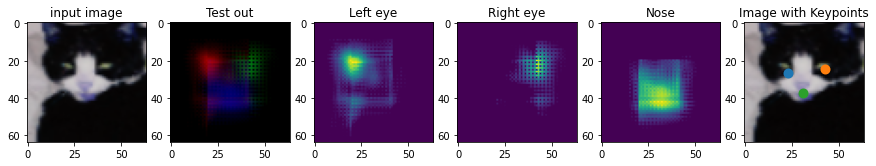

predicted value shape  (64, 64, 3)
(64, 64)


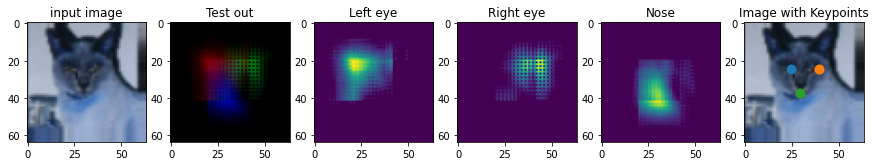

predicted value shape  (64, 64, 3)
(64, 64)


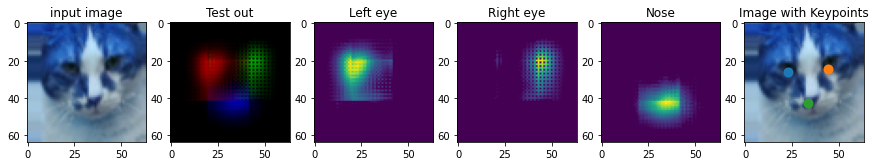

predicted value shape  (64, 64, 3)
(64, 64)


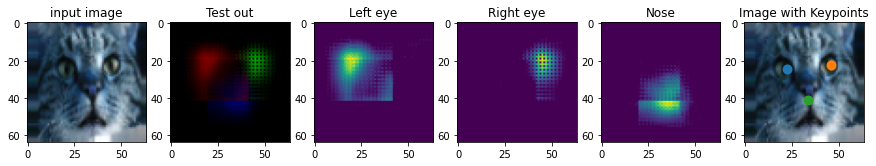

predicted value shape  (64, 64, 3)
(64, 64)


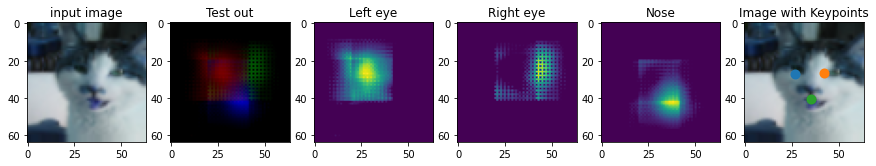

predicted value shape  (64, 64, 3)
(64, 64)


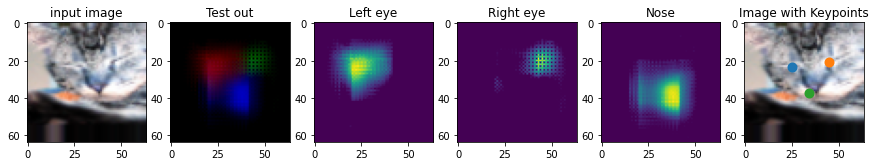

In [ ]:
batch=next(test_it)     # returns the next batch of images and labels 
print("batch shape ", batch[0].shape) # batch[0] is the images, batch[1] are the labels

for i in range(6):
  
  img=batch[0][i]     # this is the first image  batch[0][1] would be the next image

  plt.figure(figsize=(15,15))

  plt.subplot(1,6,1)
  plt.imshow(img)
  plt.title("input image")

  input = img

  img = tf.expand_dims(img, axis=0)
  test_out = model.predict(img)

  test_out = test_out[-1,:,:,:]
  

  r = test_out[:,:,0]
  g= test_out[:,:,1]
  b = test_out[:,:,2]

  print ("predicted value shape ", test_out.shape)

  plt.subplot(1,6,2)
  plt.imshow(test_out)
  plt.title("Test out")

  plt.subplot(1,6,3)
  plt.imshow(r)
  plt.title("Left eye")

  plt.subplot(1,6,4)
  plt.imshow(g)
  plt.title("Right eye")

  plt.subplot(1,6,5)
  plt.imshow(b)
  plt.title("Nose")

  print(r.shape)
  x = range(0, r.shape[0])
  y = range(0, r.shape[1])

  (X,Y) = np.meshgrid(x,y)

  r_x_coord = (X*r).sum() / r.sum().astype("float")
  r_y_coord = (Y*r).sum() / r.sum().astype("float")

  g_x_coord = (X*g).sum() / g.sum().astype("float")
  g_y_coord = (Y*g).sum() / g.sum().astype("float")

  b_x_coord = (X*b).sum() / b.sum().astype("float")
  b_y_coord = (Y*b).sum() / b.sum().astype("float")


  plt.subplot(1,6,6)
  
  plt.scatter(r_x_coord,r_y_coord,linewidths=4)
  plt.scatter(g_x_coord,g_y_coord,linewidths=4)
  plt.scatter(b_x_coord,b_y_coord,linewidths=4)

  plt.imshow(input, cmap='gray')
  plt.title("Image with Keypoints")
  plt.show()


  # print("Left eye coodinates: ",r_x_coord,r_y_coord)
  # print("Right eye coordinates: ",g_x_coord, g_y_coord)
  # print("Nose coorinates: ", b_x_coord,b_y_coord)